# CLO ANALYSIS TOOL

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
from numpy_financial import irr

In [2]:
class Loan:
    """Represents an individual loan in the CLO collateral pool"""
    
    def __init__(self, principal, interest_rate, maturity_years, default_prob=0.03, 
                 recovery_rate=0.60, prepayment_prob=0.05, industry="", rating=""):
        self.principal = principal
        self.interest_rate = interest_rate  # Annual interest rate
        self.maturity = maturity_years
        self.default_prob = default_prob    # Annual probability of default
        self.recovery_rate = recovery_rate  # Recovery rate in case of default
        self.prepayment_prob = prepayment_prob  # Annual probability of prepayment
        self.industry = industry
        self.rating = rating
        self.remaining_principal = principal
        self.defaulted = False
        self.prepaid = False
        
    def simulate_period(self, period_length=0.25):  # Quarterly by default
        """Simulate loan performance for a single period"""
        if self.defaulted or self.prepaid or self.remaining_principal <= 0:
            return 0, 0, 0
            
        # Scale probabilities to period length
        period_default_prob = 1 - (1 - self.default_prob) ** period_length
        period_prepay_prob = 1 - (1 - self.prepayment_prob) ** period_length
        
        # Check for default
        if random.random() < period_default_prob:
            self.defaulted = True
            recovery_amount = self.remaining_principal * self.recovery_rate
            self.remaining_principal = 0
            return 0, recovery_amount, 0
            
        # Check for prepayment
        if random.random() < period_prepay_prob:
            self.prepaid = True
            prepayment = self.remaining_principal
            self.remaining_principal = 0
            interest = prepayment * self.interest_rate * period_length
            return interest, 0, prepayment
            
        # Regular payment
        interest = self.remaining_principal * self.interest_rate * period_length
        
        # Assume interest-only loans for simplicity
        # For amortizing loans, you would calculate principal reduction here
        return interest, 0, 0
        
    def get_remaining_principal(self):
        """Return the remaining principal of the loan"""
        return 0 if self.defaulted else self.remaining_principal

In [3]:
class CollateralPool:
    """Represents the pool of loans serving as collateral for the CLO"""
    
    def __init__(self):
        self.loans = []
        
    def add_loan(self, loan):
        """Add a loan to the collateral pool"""
        self.loans.append(loan)
        
    def add_random_loans(self, count, avg_principal=1e6, std_principal=2e5,
                          avg_rate=0.06, std_rate=0.01,
                          avg_maturity=5, std_maturity=1):
        """Add randomly generated loans to the pool"""
        industries = ["Technology", "Healthcare", "Finance", "Energy", "Consumer", "Industrial", "Real Estate"]
        ratings = ["BB+", "BB", "BB-", "B+", "B", "B-", "CCC+"]
        
        for _ in range(count):
            principal = max(100000, np.random.normal(avg_principal, std_principal))
            rate = max(0.02, np.random.normal(avg_rate, std_rate))
            maturity = max(1, np.random.normal(avg_maturity, std_maturity))
            default_prob = max(0.01, min(0.2, np.random.gamma(3, 0.01)))
            recovery_rate = max(0.3, min(0.8, np.random.beta(5, 3)))
            prepayment_prob = max(0.01, min(0.2, np.random.beta(2, 10)))
            industry = random.choice(industries)
            rating = random.choice(ratings)
            
            loan = Loan(principal, rate, maturity, default_prob, recovery_rate, 
                        prepayment_prob, industry, rating)
            self.loans.append(loan)
            
    def total_principal(self):
        """Calculate the total outstanding principal in the pool"""
        return sum(loan.get_remaining_principal() for loan in self.loans)
        
    def simulate_period(self, period_length=0.25):
        """Simulate collateral pool performance for one period"""
        total_interest = 0
        total_recovery = 0
        total_prepayment = 0
        
        for loan in self.loans:
            interest, recovery, prepayment = loan.simulate_period(period_length)
            total_interest += interest
            total_recovery += recovery
            total_prepayment += prepayment
            
        return total_interest, total_recovery, total_prepayment
        
    def weighted_average_rate(self):
        """Calculate the weighted average interest rate of the pool"""
        if self.total_principal() == 0:
            return 0
            
        weighted_sum = sum(loan.interest_rate * loan.get_remaining_principal() 
                           for loan in self.loans)
        return weighted_sum / self.total_principal()
        
    def pool_statistics(self):
        """Return key statistics about the collateral pool"""
        active_loans = [loan for loan in self.loans if loan.get_remaining_principal() > 0]
        
        if not active_loans:
            return {
                "count": 0,
                "total_principal": 0,
                "avg_interest_rate": 0,
                "weighted_avg_rate": 0
            }
            
        total_prin = sum(loan.get_remaining_principal() for loan in active_loans)
        avg_rate = sum(loan.interest_rate for loan in active_loans) / len(active_loans)
        
        return {
            "count": len(active_loans),
            "total_principal": total_prin,
            "avg_interest_rate": avg_rate,
            "weighted_avg_rate": self.weighted_average_rate(),
            "defaulted_count": sum(1 for loan in self.loans if loan.defaulted),
            "prepaid_count": sum(1 for loan in self.loans if loan.prepaid)
        }
        
    def calculate_portfolio_metrics(self):
        """Calculate key portfolio metrics including industry concentrations and rating distributions"""
        if not self.loans:
            return {}, {}
            
        # Calculate industry concentrations
        industry_total = {}
        for loan in self.loans:
            if loan.get_remaining_principal() > 0:
                industry_total[loan.industry] = industry_total.get(loan.industry, 0) + loan.get_remaining_principal()
                
        total_principal = self.total_principal()
        industry_pct = {industry: amount/total_principal for industry, amount in industry_total.items()}
        
        # Calculate rating distributions
        rating_total = {}
        for loan in self.loans:
            if loan.get_remaining_principal() > 0:
                rating_total[loan.rating] = rating_total.get(loan.rating, 0) + loan.get_remaining_principal()
                
        rating_pct = {rating: amount/total_principal for rating, amount in rating_total.items()}
        
        return industry_pct, rating_pct

In [4]:
class CLOTranche:
    """Represents a single tranche in the CLO capital structure"""
    
    def __init__(self, principal, coupon_rate, subordination, tranche_name=""):
        self.principal = principal
        self.remaining_principal = principal
        self.coupon_rate = coupon_rate  # Annual coupon rate
        self.subordination = subordination  # Subordination percentage
        self.name = tranche_name
        self.interest_due = 0  # Accrued but unpaid interest
        self.interest_shortfall = 0  # Cumulative interest shortfall
        
    def calculate_interest(self, period_length=0.25):
        """Calculate interest due for the period"""
        period_interest = self.remaining_principal * self.coupon_rate * period_length
        self.interest_due += period_interest
        return period_interest
        
    def receive_interest_payment(self, amount):
        """Receive interest payment and update shortfall"""
        payment = min(amount, self.interest_due)
        self.interest_due -= payment
        if self.interest_due > 0:
            self.interest_shortfall += self.interest_due
        return payment
        
    def receive_principal_payment(self, amount):
        """Receive principal payment"""
        payment = min(amount, self.remaining_principal)
        self.remaining_principal -= payment
        return payment
        
    def current_balance(self):
        """Return the current balance of the tranche"""
        return self.remaining_principal

In [5]:
class CLOStructure:
    """Represents the full CLO capital structure with multiple tranches and waterfall"""
    
    def __init__(self, collateral_pool):
        self.collateral_pool = collateral_pool
        self.tranches = []
        self.equity = 0  # Equity/residual tranche
        self.reinvestment_period = 3  # Years of reinvestment period
        self.current_period = 0  # Current period number
        self.period_length = 0.25  # Quarterly by default
        self.reserve_account = 0  # Reserve account for coverage tests
        self.manager_fee_rate = 0.0015  # 15 basis points of collateral balance
        self.trustee_fee_rate = 0.0005  # 5 basis points of collateral balance
        self.cash_flow_history = []  # Store historical cash flows
        self.metrics_history = []  # Store historical CLO metrics
        
    def add_tranche(self, principal, coupon_rate, subordination, name=""):
        """Add a tranche to the CLO structure"""
        tranche = CLOTranche(principal, coupon_rate, subordination, name)
        self.tranches.append(tranche)
        # Sort tranches by subordination (highest subordination = most senior)
        self.tranches.sort(key=lambda x: x.subordination, reverse=True)
        
    def set_equity(self, equity_amount):
        """Set the equity/residual tranche amount"""
        self.equity = equity_amount
        
    def total_liabilities(self):
        """Calculate total liabilities including equity"""
        debt = sum(tranche.current_balance() for tranche in self.tranches)
        return debt + self.equity
        
    def calculate_overcollateralization(self, tranche_index):
        """Calculate the overcollateralization ratio for a specific tranche"""
        if tranche_index >= len(self.tranches):
            return float('inf')
            
        collateral_value = self.collateral_pool.total_principal()
        senior_debt = sum(t.remaining_principal for t in self.tranches[:tranche_index+1])
        
        if senior_debt == 0:
            return float('inf')
            
        return collateral_value / senior_debt
        
    def calculate_interest_coverage(self, tranche_index, expected_interest):
        """Calculate the interest coverage ratio for a specific tranche"""
        if tranche_index >= len(self.tranches):
            return float('inf')
            
        senior_interest = sum(t.coupon_rate * t.remaining_principal * self.period_length 
                             for t in self.tranches[:tranche_index+1])
        
        if senior_interest == 0:
            return float('inf')
            
        return expected_interest / senior_interest
        
    def check_coverage_tests(self, expected_interest):
        """Check if all coverage tests are passed"""
        results = {}
        for i, tranche in enumerate(self.tranches):
            oc_ratio = self.calculate_overcollateralization(i)
            ic_ratio = self.calculate_interest_coverage(i, expected_interest)
            
            # Default OC and IC test thresholds - would be specified in CLO documentation
            oc_test_threshold = 1.0 + (0.05 * (len(self.tranches) - i))  # Higher for more senior tranches
            ic_test_threshold = 1.0 + (0.1 * (len(self.tranches) - i))
            
            results[tranche.name] = {
                "oc_ratio": oc_ratio,
                "oc_test": oc_ratio >= oc_test_threshold,
                "oc_threshold": oc_test_threshold,
                "ic_ratio": ic_ratio,
                "ic_test": ic_ratio >= ic_test_threshold,
                "ic_threshold": ic_test_threshold
            }
            
        return results
        
    def apply_cash_flow_waterfall(self, interest, recovery, prepayment):
        """Apply the cash flow waterfall for a payment period"""
        # Calculate fees
        collateral_balance = self.collateral_pool.total_principal()
        manager_fee = collateral_balance * self.manager_fee_rate * self.period_length
        trustee_fee = collateral_balance * self.trustee_fee_rate * self.period_length
        
        # Total available cash for distribution
        total_cash = interest + recovery + prepayment + self.reserve_account
        
        # Pay fees
        if total_cash >= manager_fee + trustee_fee:
            total_cash -= (manager_fee + trustee_fee)
        else:
            # Not enough to pay fees
            # In a real CLO, this might accrue or have a different treatment
            total_cash = 0
            
        # Interest waterfall
        interest_payments = {}
        for tranche in self.tranches:
            tranche.calculate_interest(self.period_length)
            if total_cash > 0:
                interest_payment = tranche.receive_interest_payment(total_cash)
                interest_payments[tranche.name] = interest_payment
                total_cash -= interest_payment
            else:
                interest_payments[tranche.name] = 0
                
        # Check coverage tests
        coverage_tests = self.check_coverage_tests(interest)
        tests_failed = any(not result["oc_test"] or not result["ic_test"] 
                          for result in coverage_tests.values())
                
        # Principal waterfall
        principal_payments = {}
        remaining_principal = prepayment + recovery
        
        if tests_failed or self.current_period * self.period_length >= self.reinvestment_period:
            # If tests failed or after reinvestment period, pay down notes
            for tranche in self.tranches:
                if remaining_principal > 0:
                    principal_payment = tranche.receive_principal_payment(remaining_principal)
                    principal_payments[tranche.name] = principal_payment
                    remaining_principal -= principal_payment
                else:
                    principal_payments[tranche.name] = 0
        else:
            # During reinvestment period with tests passing, reinvest principal
            principal_payments = {tranche.name: 0 for tranche in self.tranches}
            # In a real model, would add new loans here with the reinvestment amount
            
        # Equity distribution
        equity_distribution = total_cash
        
        # Store results for this period
        result = {
            "period": self.current_period,
            "interest_collected": interest,
            "recovery_collected": recovery,
            "prepayment_collected": prepayment,
            "manager_fee": manager_fee,
            "trustee_fee": trustee_fee,
            "interest_payments": interest_payments,
            "principal_payments": principal_payments,
            "equity_distribution": equity_distribution,
            "coverage_tests": coverage_tests,
            "tests_failed": tests_failed,
            "reserve_account": self.reserve_account
        }
        
        self.cash_flow_history.append(result)
        
        # Update reserve account for next period
        self.reserve_account = remaining_principal if tests_failed else 0
        
        # Calculate and store CLO metrics
        metrics = self.calculate_clo_metrics()
        self.metrics_history.append(metrics)
        
        return result
        
    def simulate_period(self):
        """Simulate a single payment period"""
        # Simulate the collateral pool
        interest, recovery, prepayment = self.collateral_pool.simulate_period(self.period_length)
        
        # Apply the cash flow waterfall
        result = self.apply_cash_flow_waterfall(interest, recovery, prepayment)
        
        # Increment period counter
        self.current_period += 1
        
        return result
        
    def simulate_to_maturity(self, max_periods=40):  # 10 years by default
        """Simulate the CLO to maturity or for a specified number of periods"""
        results = []
        
        for _ in range(max_periods):
            # Check if all tranches are paid off
            if all(tranche.remaining_principal == 0 for tranche in self.tranches):
                break
                
            result = self.simulate_period()
            results.append(result)
            
        return results
        
    def calculate_clo_metrics(self):
        """Calculate key CLO metrics"""
        collateral_stats = self.collateral_pool.pool_statistics()
        
        # Calculate tranche information
        tranche_info = {}
        for tranche in self.tranches:
            tranche_info[tranche.name] = {
                "original_balance": tranche.principal,
                "current_balance": tranche.remaining_principal,
                "percent_outstanding": tranche.remaining_principal / tranche.principal if tranche.principal > 0 else 0,
                "coupon_rate": tranche.coupon_rate,
                "interest_shortfall": tranche.interest_shortfall
            }
            
        # Calculate portfolio metrics
        industry_concentration, rating_distribution = self.collateral_pool.calculate_portfolio_metrics()
        
        return {
            "period": self.current_period,
            "collateral_stats": collateral_stats,
            "tranche_info": tranche_info,
            "industry_concentration": industry_concentration,
            "rating_distribution": rating_distribution,
            "total_liabilities": self.total_liabilities(),
            "leverage_ratio": self.collateral_pool.total_principal() / self.equity if self.equity > 0 else 0
        }
        
    def get_performance_summary(self):
        """Get a summary of CLO performance to date with fixed IRR handling"""
        if not self.metrics_history:
            return "No simulation data available."
            
        latest = self.metrics_history[-1]
        initial = self.metrics_history[0]
    
        # Calculate returns for equity
        equity_distributions = [cf["equity_distribution"] for cf in self.cash_flow_history]
        total_equity_return = sum(equity_distributions)
    
        # Fix: Handle the case where IRR calculation returns None
        equity_irr = self.calculate_irr([-self.equity] + equity_distributions, self.period_length)
    
        default_rate = sum(1 for loan in self.collateral_pool.loans if loan.defaulted) / len(self.collateral_pool.loans)
        prepayment_rate = sum(1 for loan in self.collateral_pool.loans if loan.prepaid) / len(self.collateral_pool.loans)
    
        summary = {
            "periods_completed": self.current_period,
            "years_completed": self.current_period * self.period_length,
            "original_collateral": initial["collateral_stats"]["total_principal"],
            "current_collateral": latest["collateral_stats"]["total_principal"],
            "collateral_reduction": 1 - (latest["collateral_stats"]["total_principal"] / initial["collateral_stats"]["total_principal"]) if initial["collateral_stats"]["total_principal"] > 0 else 0,
            "default_rate": default_rate,
            "prepayment_rate": prepayment_rate,
            "equity_total_return": total_equity_return,
            "equity_total_return_pct": total_equity_return / self.equity if self.equity > 0 else 0,
            "equity_irr": equity_irr if equity_irr is not None else 0.0,  # Fix: Default to 0.0 if None
            "coverage_test_failures": sum(1 for cf in self.cash_flow_history if cf["tests_failed"])
        }
    
        return summary
        
    def calculate_irr(self, cash_flows, period_length):
        """Calculate IRR using numpy's irr function with improved error handling"""
        try:
            if len(cash_flows) < 2:
                return 0.0
            
            # Filter near-zero cash flows
            cash_flows = [cf if abs(cf) > 1e-6 else 0 for cf in cash_flows]
        
            rate = irr(cash_flows)
            if np.isnan(rate) or isinstance(rate, complex):
                return 0.0
            
            annual_rate = (1 + rate) ** (1/period_length) - 1
            return annual_rate if not np.isnan(annual_rate) else 0.0
        except:
            return 0.0

In [6]:
class CLOAnalyzer:
    """Tools for analyzing CLO performance and running simulations"""
    
    @staticmethod
    def run_monte_carlo_simulation(clo_structure, num_simulations=100, periods=20):
        """Run Monte Carlo simulations to analyze CLO performance under different scenarios"""
        results = []
        
        for sim in range(num_simulations):
            # Create a deep copy of the CLO for this simulation
            # In a real implementation, you would need to clone the CLO structure properly
            # This simplified version creates a new CLO with similar properties
            new_pool = CollateralPool()
            new_pool.add_random_loans(len(clo_structure.collateral_pool.loans))
            
            new_clo = CLOStructure(new_pool)
            # Copy tranche structure from original CLO
            for tranche in clo_structure.tranches:
                new_clo.add_tranche(tranche.principal, tranche.coupon_rate, 
                                    tranche.subordination, tranche.name)
            new_clo.set_equity(clo_structure.equity)
            
            # Run simulation
            new_clo.simulate_to_maturity(periods)
            summary = new_clo.get_performance_summary()
            results.append(summary)
            
        return results
        
    @staticmethod
    def stress_test(clo_structure, stress_scenarios):
        """Apply stress scenarios to the CLO structure"""
        results = {}
        
        for scenario_name, scenario in stress_scenarios.items():
            # Create a copy of the CLO
            new_pool = CollateralPool()
            
            # Apply scenario adjustments
            default_multiplier = scenario.get('default_multiplier', 1.0)
            recovery_multiplier = scenario.get('recovery_multiplier', 1.0)
            prepayment_multiplier = scenario.get('prepayment_multiplier', 1.0)
            
            # Add loans with stressed parameters
            for loan in clo_structure.collateral_pool.loans:
                new_loan = Loan(
                    loan.principal,
                    loan.interest_rate,
                    loan.maturity,
                    loan.default_prob * default_multiplier,
                    loan.recovery_rate * recovery_multiplier,
                    loan.prepayment_prob * prepayment_multiplier,
                    loan.industry,
                    loan.rating
                )
                new_pool.loans.append(new_loan)
                
            # Create new CLO with stressed pool
            new_clo = CLOStructure(new_pool)
            for tranche in clo_structure.tranches:
                new_clo.add_tranche(tranche.principal, tranche.coupon_rate, 
                                   tranche.subordination, tranche.name)
            new_clo.set_equity(clo_structure.equity)
            
            # Run simulation
            new_clo.simulate_to_maturity()
            results[scenario_name] = new_clo.get_performance_summary()
            
        return results
        
    @staticmethod
    def analyze_tranche_performance(clo_results):
        """Analyze tranche performance based on simulation results"""
        if not clo_results:
            return {}
            
        last_period = clo_results[-1]
        first_period = clo_results[0]
        
        tranche_analysis = {}
        
        # Extract tranche names from the first period
        tranche_names = list(first_period["interest_payments"].keys())
        
        for tranche_name in tranche_names:
            # Calculate total interest payments
            total_interest = sum(period["interest_payments"].get(tranche_name, 0) 
                                for period in clo_results)
            
            # Calculate total principal payments
            total_principal = sum(period["principal_payments"].get(tranche_name, 0) 
                                 for period in clo_results)
            
            # Extract original and final balance from cash flow history
            # This assumes the CLO object has stored metrics history
            
            tranche_analysis[tranche_name] = {
                "total_interest_paid": total_interest,
                "total_principal_paid": total_principal,
                "periods_to_repayment": None  # Will fill this in below
            }
            
            # Calculate periods to repayment
            for i, period in enumerate(clo_results):
                principal_payment = period["principal_payments"].get(tranche_name, 0)
                if principal_payment > 0:
                    tranche_analysis[tranche_name]["periods_to_repayment"] = i
                    break
                    
        return tranche_analysis
        
    @staticmethod
    def plot_waterfall(clo):
        """Create a waterfall chart showing the CLO capital structure"""
        if not clo.tranches:
            return "No tranches defined."
            
        # Calculate total CLO size
        total_size = sum(tranche.principal for tranche in clo.tranches) + clo.equity
        
        # Create data for the chart
        tranche_data = []
        cumulative = 0
        
        for i, tranche in enumerate(clo.tranches):
            percentage = tranche.principal / total_size * 100
            tranche_data.append({
                'name': tranche.name if tranche.name else f"Tranche {i+1}",
                'amount': tranche.principal,
                'percentage': percentage,
                'coupon': tranche.coupon_rate * 100,  # Convert to percentage
                'subordination': tranche.subordination * 100,  # Convert to percentage
                'cumulative': cumulative + percentage
            })
            cumulative += percentage
            
        # Add equity tranche
        equity_percentage = clo.equity / total_size * 100
        tranche_data.append({
            'name': 'Equity',
            'amount': clo.equity,
            'percentage': equity_percentage,
            'coupon': None,
            'subordination': 0,
            'cumulative': cumulative + equity_percentage
        })
        
        # Create a DataFrame from the data
        df = pd.DataFrame(tranche_data)
        
        # Create the plot
        plt.figure(figsize=(10, 8))
        plt.barh(df['name'], df['percentage'], color=['#1f77b4' if i < len(df)-1 else '#2ca02c' 
                                                     for i in range(len(df))])
        
        # Add percentage and amount labels
        for i, (percentage, amount) in enumerate(zip(df['percentage'], df['amount'])):
            plt.text(percentage/2, i, f"{percentage:.1f}%\n${amount/1e6:.1f}M", 
                     ha='center', va='center', color='white')
            
        # Add coupon labels for debt tranches
        for i, (name, coupon) in enumerate(zip(df['name'], df['coupon'])):
            if coupon is not None:
                plt.text(df['percentage'][i] + 1, i, f"Coupon: {coupon:.2f}%", 
                         ha='left', va='center')
        
        plt.title('CLO Capital Structure')
        plt.xlabel('Percentage of Total CLO')
        plt.grid(axis='x', alpha=0.3)
        plt.xlim(0, 100)
        plt.tight_layout()
        
        return plt
        
    @staticmethod
    def plot_cash_flows(clo):
        """Plot cash flows over time"""
        if not clo.cash_flow_history:
            return "No cash flow data available."
            
        periods = len(clo.cash_flow_history)
        
        # Extract data from cash flow history
        interest_data = [cf["interest_collected"] for cf in clo.cash_flow_history]
        recovery_data = [cf["recovery_collected"] for cf in clo.cash_flow_history]
        prepayment_data = [cf["prepayment_collected"] for cf in clo.cash_flow_history]
        equity_data = [cf["equity_distribution"] for cf in clo.cash_flow_history]
        
        x = list(range(1, periods + 1))
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.bar(x, interest_data, label='Interest')
        plt.bar(x, recovery_data, bottom=interest_data, label='Recovery')
        plt.bar(x, prepayment_data, bottom=[i+r for i, r in zip(interest_data, recovery_data)], 
                label='Prepayment')
        plt.title('CLO Collections by Period')
        plt.xlabel('Period')
        plt.ylabel('Amount ($)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(x, equity_data, 'g-', marker='o', label='Equity Distribution')
        plt.title('Equity Distributions by Period')
        plt.xlabel('Period')
        plt.ylabel('Amount ($)')
        plt.grid(alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        
        return plt
        
    @staticmethod
    def plot_coverage_tests(clo):
        """Plot coverage test results over time"""
        if not clo.cash_flow_history:
            return "No cash flow data available."
            
        # Get tranche names
        tranches = list(clo.cash_flow_history[0]["coverage_tests"].keys())
        periods = len(clo.cash_flow_history)
        
        plt.figure(figsize=(12, 10))
        
        # Plot OC ratios
        plt.subplot(2, 1, 1)
        for tranche in tranches:
            oc_data = [cf["coverage_tests"][tranche]["oc_ratio"] for cf in clo.cash_flow_history]
            threshold = clo.cash_flow_history[0]["coverage_tests"][tranche]["oc_threshold"]
            plt.plot(range(1, periods + 1), oc_data, marker='o', label=f'{tranche} OC')
            plt.axhline(y=threshold, linestyle='--', alpha=0.5, 
                       label=f'{tranche} OC Threshold ({threshold:.2f})')
            
        plt.title('Overcollateralization Ratios')
        plt.xlabel('Period')
        plt.ylabel('OC Ratio')
        plt.grid(alpha=0.3)
        plt.legend()

        # Plot IC ratios
        plt.subplot(2, 1, 2)
        for tranche in tranches:
            ic_data = [cf["coverage_tests"][tranche]["ic_ratio"] for cf in clo.cash_flow_history]
            threshold = clo.cash_flow_history[0]["coverage_tests"][tranche]["ic_threshold"]
            plt.plot(range(1, periods + 1), ic_data, marker='o', label=f'{tranche} IC')
            plt.axhline(y=threshold, linestyle='--', alpha=0.5, 
                       label=f'{tranche} IC Threshold ({threshold:.2f})')
            
        plt.title('Interest Coverage Ratios')
        plt.xlabel('Period')
        plt.ylabel('IC Ratio')
        plt.grid(alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        
        return plt

In [7]:
def create_sample_clo():
    """Create a sample CLO structure for demonstration"""
    # Create collateral pool
    pool = CollateralPool()
    pool.add_random_loans(100)  # Add 100 random loans
    
    # Create CLO structure
    clo = CLOStructure(pool)
    
    # Define tranches
    # Class A - Senior Tranche (AAA)
    clo.add_tranche(70000000, 0.0350, 0.95, "Class A")
    
    # Class B - Mezzanine Tranche (AA)
    clo.add_tranche(10000000, 0.0450, 0.85, "Class B")
    
    # Class C - Mezzanine Tranche (A)
    clo.add_tranche(7000000, 0.0550, 0.78, "Class C")
    
    # Class D - Mezzanine Tranche (BBB)
    clo.add_tranche(5000000, 0.0650, 0.73, "Class D")
    
    # Class E - Subordinated Tranche (BB)
    clo.add_tranche(3000000, 0.0900, 0.70, "Class E")
    
    # Equity
    clo.set_equity(5000000)
    
    return clo

In [8]:
def advanced_scenario_modeling(clo_structure, scenarios, stress_factors):
    """
    Perform advanced scenario modeling with correlation between risk factors
    
    Parameters:
        clo_structure: The base CLO structure to model
        scenarios: Dictionary of scenario names and probabilities
        stress_factors: Dictionary of stress factors for different parameters
    """
    results = {}
    
    for scenario_name, probability in scenarios.items():
        # Create new pool for this scenario
        new_pool = CollateralPool()
        
        # Apply correlated stress factors based on scenario
        default_factor = stress_factors[scenario_name]['default']
        recovery_factor = stress_factors[scenario_name]['recovery']
        prepayment_factor = stress_factors[scenario_name]['prepayment']
        
        # Get base parameters
        base_default = [loan.default_prob for loan in clo_structure.collateral_pool.loans]
        base_recovery = [loan.recovery_rate for loan in clo_structure.collateral_pool.loans]
        base_prepayment = [loan.prepayment_prob for loan in clo_structure.collateral_pool.loans]
        
        # Generate correlated random factors
        correlation_matrix = np.array([
            [1.0, -0.7, -0.3],    # Default correlated negatively with recovery and prepayment
            [-0.7, 1.0, 0.2],     # Recovery correlated negatively with default, slightly with prepayment
            [-0.3, 0.2, 1.0]      # Prepayment has weaker correlations
        ])
        
        # For each loan, apply correlated stress
        for i, loan in enumerate(clo_structure.collateral_pool.loans):
            # Generate correlated random variables
            mean = [0, 0, 0]
            random_factors = np.random.multivariate_normal(mean, correlation_matrix)
            
            # Apply stress with random variation
            stressed_default = loan.default_prob * default_factor * (1 + 0.2 * random_factors[0])
            stressed_recovery = loan.recovery_rate * recovery_factor * (1 + 0.1 * random_factors[1])
            stressed_prepayment = loan.prepayment_prob * prepayment_factor * (1 + 0.15 * random_factors[2])
            
            # Ensure values are within valid ranges
            stressed_default = max(0.001, min(0.5, stressed_default))
            stressed_recovery = max(0.1, min(0.9, stressed_recovery))
            stressed_prepayment = max(0.001, min(0.3, stressed_prepayment))
            
            # Create stressed loan
            new_loan = Loan(
                loan.principal,
                loan.interest_rate,
                loan.maturity,
                stressed_default,
                stressed_recovery,
                stressed_prepayment,
                loan.industry,
                loan.rating
            )
            new_pool.loans.append(new_loan)
        
        # Create new CLO with stressed pool
        new_clo = CLOStructure(new_pool)
        for tranche in clo_structure.tranches:
            new_clo.add_tranche(tranche.principal, tranche.coupon_rate, 
                               tranche.subordination, tranche.name)
        new_clo.set_equity(clo_structure.equity)
        
        # Run simulation
        new_clo.simulate_to_maturity()
        results[scenario_name] = {
            'probability': probability,
            'summary': new_clo.get_performance_summary(),
            'metrics_history': new_clo.metrics_history,
            'cash_flow_history': new_clo.cash_flow_history
        }
    
    # Calculate expected values across scenarios
    expected_values = calculate_expected_values(results)
    
    return results, expected_values

In [9]:
def calculate_expected_values(scenario_results):
    """Calculate expected values across different scenarios based on their probabilities"""
    expected = {
        'equity_irr': 0,
        'default_rate': 0,
        'recovery_rate': 0,
        'tranche_losses': {}
    }
    
    total_probability = sum(result['probability'] for result in scenario_results.values())
    
    # Normalize probabilities if they don't sum to 1
    if abs(total_probability - 1.0) > 0.001:
        for scenario in scenario_results:
            scenario_results[scenario]['probability'] /= total_probability
    
    # Calculate expected values
    for scenario, result in scenario_results.items():
        probability = result['probability']
        summary = result['summary']
        
        # Weighted average of key metrics
        expected['equity_irr'] += summary.get('equity_irr', 0) * probability
        expected['default_rate'] += summary.get('default_rate', 0) * probability
        
        # Calculate tranche losses for this scenario
        for cf in result['cash_flow_history']:
            for tranche_name in cf['interest_payments']:
                if tranche_name not in expected['tranche_losses']:
                    expected['tranche_losses'][tranche_name] = 0
                
                # Accumulate expected interest shortfalls
                interest_due = cf.get('interest_due', {}).get(tranche_name, 0)
                interest_paid = cf['interest_payments'].get(tranche_name, 0)
                shortfall = interest_due - interest_paid
                
                if shortfall > 0:
                    expected['tranche_losses'][tranche_name] += shortfall * probability
    
    return expected

In [10]:
def perform_sensitivity_analysis(base_clo, variables, ranges):
    """
    Perform sensitivity analysis on key variables
    
    Parameters:
        base_clo: Base CLO structure
        variables: List of variables to analyze
        ranges: Dictionary of ranges for each variable
    """
    results = {}
    
    for variable in variables:
        variable_results = []
        
        for value in ranges[variable]:
            # Create a copy of the base CLO
            new_pool = CollateralPool()
            
            # Apply the variable change
            if variable == 'default_rate':
                multiplier = value / base_pool_average(base_clo.collateral_pool, 'default_prob')
                for loan in base_clo.collateral_pool.loans:
                    new_loan = Loan(
                        loan.principal,
                        loan.interest_rate,
                        loan.maturity,
                        loan.default_prob * multiplier,
                        loan.recovery_rate,
                        loan.prepayment_prob,
                        loan.industry,
                        loan.rating
                    )
                    new_pool.loans.append(new_loan)
            
            elif variable == 'recovery_rate':
                multiplier = value / base_pool_average(base_clo.collateral_pool, 'recovery_rate')
                for loan in base_clo.collateral_pool.loans:
                    new_loan = Loan(
                        loan.principal,
                        loan.interest_rate,
                        loan.maturity,
                        loan.default_prob,
                        loan.recovery_rate * multiplier,
                        loan.prepayment_prob,
                        loan.industry,
                        loan.rating
                    )
                    new_pool.loans.append(new_loan)
            
            elif variable == 'prepayment_rate':
                multiplier = value / base_pool_average(base_clo.collateral_pool, 'prepayment_prob')
                for loan in base_clo.collateral_pool.loans:
                    new_loan = Loan(
                        loan.principal,
                        loan.interest_rate,
                        loan.maturity,
                        loan.default_prob,
                        loan.recovery_rate,
                        loan.prepayment_prob * multiplier,
                        loan.industry,
                        loan.rating
                    )
                    new_pool.loans.append(new_loan)
            
            elif variable == 'interest_rates':
                # For interest rates, we change both loan rates and tranche coupons
                rate_change = value - base_pool_average(base_clo.collateral_pool, 'interest_rate')
                
                for loan in base_clo.collateral_pool.loans:
                    new_loan = Loan(
                        loan.principal,
                        max(0.01, loan.interest_rate + rate_change),
                        loan.maturity,
                        loan.default_prob,
                        loan.recovery_rate,
                        loan.prepayment_prob,
                        loan.industry,
                        loan.rating
                    )
                    new_pool.loans.append(new_loan)
            
            # Create new CLO structure
            new_clo = CLOStructure(new_pool)
            
            # Add tranches, adjusting coupon rates if analyzing interest rates
            for tranche in base_clo.tranches:
                if variable == 'interest_rates':
                    new_coupon = max(0.005, tranche.coupon_rate + rate_change)
                else:
                    new_coupon = tranche.coupon_rate
                
                new_clo.add_tranche(tranche.principal, new_coupon, 
                                   tranche.subordination, tranche.name)
                
            new_clo.set_equity(base_clo.equity)
            
            # Run simulation
            new_clo.simulate_to_maturity()
            summary = new_clo.get_performance_summary()
            
            # Save key metrics
            result = {
                'variable_value': value,
                'equity_irr': summary.get('equity_irr', 0),
                'default_rate': summary.get('default_rate', 0),
                'coverage_test_failures': summary.get('coverage_test_failures', 0)
            }
            
            variable_results.append(result)
            
        results[variable] = variable_results
    
    return results

In [11]:
def base_pool_average(pool, attribute):
    """Calculate average value of an attribute in the loan pool"""
    if not pool.loans:
        return 0
    
    total = sum(getattr(loan, attribute) for loan in pool.loans)
    return total / len(pool.loans)

In [12]:
def plot_sensitivity_analysis(sensitivity_results):
    """Plot results of sensitivity analysis"""
    variables = list(sensitivity_results.keys())
    
    plt.figure(figsize=(15, 10))
    
    for i, variable in enumerate(variables):
        results = sensitivity_results[variable]
        
        # Extract data
        x_values = [r['variable_value'] for r in results]
        irr_values = [r['equity_irr'] * 100 for r in results]  # Convert to percentage
        
        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, irr_values, 'b-o')
        plt.title(f'Sensitivity of Equity IRR to {variable.replace("_", " ").title()}')
        plt.xlabel(variable.replace("_", " ").title())
        plt.ylabel('Equity IRR (%)')
        plt.grid(alpha=0.3)
        
        # Add reference line at y=0
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        
    plt.tight_layout()
    return plt

In [13]:
class CLORiskAnalyzer:
    """Advanced risk analysis for CLO structures"""
    
    @staticmethod
    def calculate_var(clo_structure, confidence_level=0.95, num_simulations=1000):
        """Calculate Value at Risk (VaR) for CLO tranches"""
        results = {}
        
        # Run simulations
        equity_returns = []
        tranche_losses = {tranche.name: [] for tranche in clo_structure.tranches}
        
        for _ in range(num_simulations):
            # Create a new CLO with similar properties but randomized parameters
            new_pool = CollateralPool()
            
            # Add loans with random stress
            for loan in clo_structure.collateral_pool.loans:
                # Apply random stress to default probabilities
                default_stress = np.random.lognormal(0, 0.5)  # Log-normal to skew towards higher defaults
                recovery_stress = np.random.beta(5, 2)  # Beta distribution for recovery rates
                
                stressed_default = min(0.5, loan.default_prob * default_stress)
                stressed_recovery = min(0.9, loan.recovery_rate * recovery_stress)
                
                new_loan = Loan(
                    loan.principal,
                    loan.interest_rate,
                    loan.maturity,
                    stressed_default,
                    stressed_recovery,
                    loan.prepayment_prob,
                    loan.industry,
                    loan.rating
                )
                new_pool.loans.append(new_loan)
            
            # Create new CLO structure
            new_clo = CLOStructure(new_pool)
            for tranche in clo_structure.tranches:
                new_clo.add_tranche(tranche.principal, tranche.coupon_rate, 
                                   tranche.subordination, tranche.name)
            new_clo.set_equity(clo_structure.equity)
            
            # Run simulation
            new_clo.simulate_to_maturity()
            summary = new_clo.get_performance_summary()
            
            # Record equity return
            equity_returns.append(summary.get('equity_irr', -1))
            
            # Record tranche losses
            for tranche in new_clo.tranches:
                loss_percentage = tranche.interest_shortfall / (tranche.principal * tranche.coupon_rate)
                tranche_losses[tranche.name].append(loss_percentage)
        
        # Calculate VaR for equity
        equity_returns = np.array(equity_returns)
        equity_var = np.percentile(equity_returns, (1 - confidence_level) * 100)
        
        # Calculate VaR for each tranche
        tranche_var = {}
        for tranche_name, losses in tranche_losses.items():
            tranche_var[tranche_name] = np.percentile(losses, confidence_level * 100)
        
        return {
            'equity_var': equity_var,
            'tranche_var': tranche_var,
            'equity_returns_distribution': equity_returns
        }
    
    @staticmethod
    def calculate_expected_shortfall(clo_structure, confidence_level=0.95, num_simulations=1000):
        """Calculate Expected Shortfall (ES) / Conditional VaR for CLO tranches"""
        # Run VaR calculation to get return distribution
        var_results = CLORiskAnalyzer.calculate_var(
            clo_structure, confidence_level, num_simulations)
        
        equity_returns = var_results['equity_returns_distribution']
        equity_var = var_results['equity_var']
        
        # Calculate Expected Shortfall for equity
        tail_returns = equity_returns[equity_returns <= equity_var]
        equity_es = np.mean(tail_returns) if len(tail_returns) > 0 else equity_var
        
        return {
            'equity_es': equity_es,
            'equity_var': equity_var
        }
    
    @staticmethod
    def calculate_concentration_risk(collateral_pool):
        """Calculate concentration risk metrics for industry and rating categories"""
        industry_total, rating_total = {}, {}
        
        # Calculate totals by industry and rating
        for loan in collateral_pool.loans:
            if loan.get_remaining_principal() > 0:
                industry_total[loan.industry] = industry_total.get(loan.industry, 0) + loan.get_remaining_principal()
                rating_total[loan.rating] = rating_total.get(loan.rating, 0) + loan.get_remaining_principal()
        
        total_principal = collateral_pool.total_principal()
        
        if total_principal == 0:
            return {'industry_hhi': 0, 'rating_hhi': 0}
        
        # Calculate Herfindahl-Hirschman Index (HHI) for concentration
        industry_pct = {k: v/total_principal for k, v in industry_total.items()}
        rating_pct = {k: v/total_principal for k, v in rating_total.items()}
        
        industry_hhi = sum(pct ** 2 for pct in industry_pct.values())
        rating_hhi = sum(pct ** 2 for pct in rating_pct.values())
        
        return {
            'industry_hhi': industry_hhi,
            'rating_hhi': rating_hhi,
            'industry_concentration': industry_pct,
            'rating_concentration': rating_pct
        }

In [14]:
def run_clo_example():
    """Run a complete example CLO analysis with error handling"""
    # Create a sample CLO
    clo = create_sample_clo()
    
    # Run baseline simulation
    print("Running CLO simulation...")
    clo.simulate_to_maturity()
    
    # Get summary
    summary = clo.get_performance_summary()
    print("\nCLO Performance Summary:")
    print(f"Periods completed: {summary['periods_completed']}")
    print(f"Original collateral: ${summary['original_collateral']:,.2f}")
    print(f"Current collateral: ${summary['current_collateral']:,.2f}")
    print(f"Default rate: {summary['default_rate']:.2%}")
    print(f"Prepayment rate: {summary['prepayment_rate']:.2%}")
    print(f"Equity total return: ${summary['equity_total_return']:,.2f}")
    
    # Fix: Handle potential None values
    equity_irr = summary.get('equity_irr', 0.0)
    print(f"Equity IRR: {equity_irr:.2%}")
    print(f"Coverage test failures: {summary['coverage_test_failures']}")
    
    # Run stress tests
    print("\nRunning stress tests...")
    stress_scenarios = {
        'baseline': {'default_multiplier': 1.0, 'recovery_multiplier': 1.0, 'prepayment_multiplier': 1.0},
        'moderate_stress': {'default_multiplier': 1.5, 'recovery_multiplier': 0.8, 'prepayment_multiplier': 0.7},
        'severe_stress': {'default_multiplier': 3.0, 'recovery_multiplier': 0.5, 'prepayment_multiplier': 0.3}
    }
    
    stress_results = CLOAnalyzer.stress_test(clo, stress_scenarios)
    
    # Print stress test results
    print("\nStress Test Results:")
    for scenario, result in stress_results.items():
        print(f"\n{scenario.upper()}:")
        print(f"Default rate: {result['default_rate']:.2%}")
        print(f"Equity IRR: {result.get('equity_irr', 0):.2%}")
        print(f"Coverage test failures: {result['coverage_test_failures']}")
    
    # Plot CLO structure
    print("\nGenerating CLO structure visualization...")
    try:
        waterfall_plot = CLOAnalyzer.plot_waterfall(clo)
    except Exception as e:
        print(f"Error generating waterfall plot: {str(e)}")
        waterfall_plot = None
    
    # Plot cash flows
    print("Generating cash flow visualization...")
    try:
        cashflow_plot = CLOAnalyzer.plot_cash_flows(clo)
    except Exception as e:
        print(f"Error generating cash flow plot: {str(e)}")
        cashflow_plot = None
    
    # Plot coverage tests
    print("Generating coverage test visualization...")
    try:
        coverage_plot = CLOAnalyzer.plot_coverage_tests(clo)
    except Exception as e:
        print(f"Error generating coverage test plot: {str(e)}")
        coverage_plot = None
    
    # Calculate risk metrics
    print("\nCalculating risk metrics...")
    risk_analyzer = CLORiskAnalyzer()
    
    try:
        var_results = risk_analyzer.calculate_var(clo)
        print("\nRisk Metrics:")
        print(f"Equity VaR (95%): {var_results['equity_var']:.2%}")
    except Exception as e:
        print(f"Error calculating VaR: {str(e)}")
        var_results = {'equity_var': 0.0}
    
    try:
        concentration_risk = risk_analyzer.calculate_concentration_risk(clo.collateral_pool)
        print(f"Industry concentration (HHI): {concentration_risk['industry_hhi']:.4f}")
        print(f"Rating concentration (HHI): {concentration_risk['rating_hhi']:.4f}")
    except Exception as e:
        print(f"Error calculating concentration risk: {str(e)}")
        concentration_risk = {'industry_hhi': 0.0, 'rating_hhi': 0.0}
    
    # Advanced scenario analysis
    print("\nRunning advanced scenario analysis...")
    scenarios = {
        'base_case': 0.5,
        'recession': 0.3,
        'expansion': 0.2
    }
    
    stress_factors = {
        'base_case': {'default': 1.0, 'recovery': 1.0, 'prepayment': 1.0},
        'recession': {'default': 2.5, 'recovery': 0.6, 'prepayment': 0.5},
        'expansion': {'default': 0.7, 'recovery': 1.2, 'prepayment': 1.5}
    }
    
    try:
        scenario_results, expected_values = advanced_scenario_modeling(clo, scenarios, stress_factors)
        print("\nExpected Values Across Scenarios:")
        print(f"Expected equity IRR: {expected_values.get('equity_irr', 0.0):.2%}")
        print(f"Expected default rate: {expected_values.get('default_rate', 0.0):.2%}")
    except Exception as e:
        print(f"Error in scenario modeling: {str(e)}")
        scenario_results, expected_values = {}, {'equity_irr': 0.0, 'default_rate': 0.0}
    
    # Sensitivity analysis
    print("\nRunning sensitivity analysis...")
    variables = ['default_rate', 'recovery_rate', 'prepayment_rate', 'interest_rates']
    ranges = {
        'default_rate': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12],
        'recovery_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'prepayment_rate': [0.02, 0.04, 0.06, 0.08, 0.10, 0.12],
        'interest_rates': [0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
    }
    
    try:
        sensitivity_results = perform_sensitivity_analysis(clo, variables, ranges)
        sensitivity_plot = plot_sensitivity_analysis(sensitivity_results)
    except Exception as e:
        print(f"Error in sensitivity analysis: {str(e)}")
        sensitivity_results = {}
        sensitivity_plot = None
    
    print("\nAnalysis complete!")
    
    return {
        'clo': clo,
        'summary': summary,
        'stress_results': stress_results,
        'scenario_results': scenario_results,
        'expected_values': expected_values,
        'sensitivity_results': sensitivity_results,
        'plots': {
            'waterfall': waterfall_plot,
            'cashflow': cashflow_plot,
            'coverage': coverage_plot,
            'sensitivity': sensitivity_plot
        }
    }

Running CLO simulation...

CLO Performance Summary:
Periods completed: 40
Original collateral: $93,920,500.26
Current collateral: $19,905,132.53
Default rate: 13.00%
Prepayment rate: 66.00%
Equity total return: $80,883,009.01
Equity IRR: 1493.81%
Coverage test failures: 40

Running stress tests...

Stress Test Results:

BASELINE:
Default rate: 13.00%
Equity IRR: 874.36%
Coverage test failures: 40

MODERATE_STRESS:
Default rate: 35.00%
Equity IRR: 473.98%
Coverage test failures: 40

SEVERE_STRESS:
Default rate: 50.00%
Equity IRR: 217.08%
Coverage test failures: 40

Generating CLO structure visualization...
Generating cash flow visualization...
Generating coverage test visualization...

Calculating risk metrics...

Risk Metrics:
Equity VaR (95%): 498.91%
Industry concentration (HHI): 0.1713
Rating concentration (HHI): 0.1708

Running advanced scenario analysis...

Expected Values Across Scenarios:
Expected equity IRR: 1392.56%
Expected default rate: 22.60%

Running sensitivity analysis..

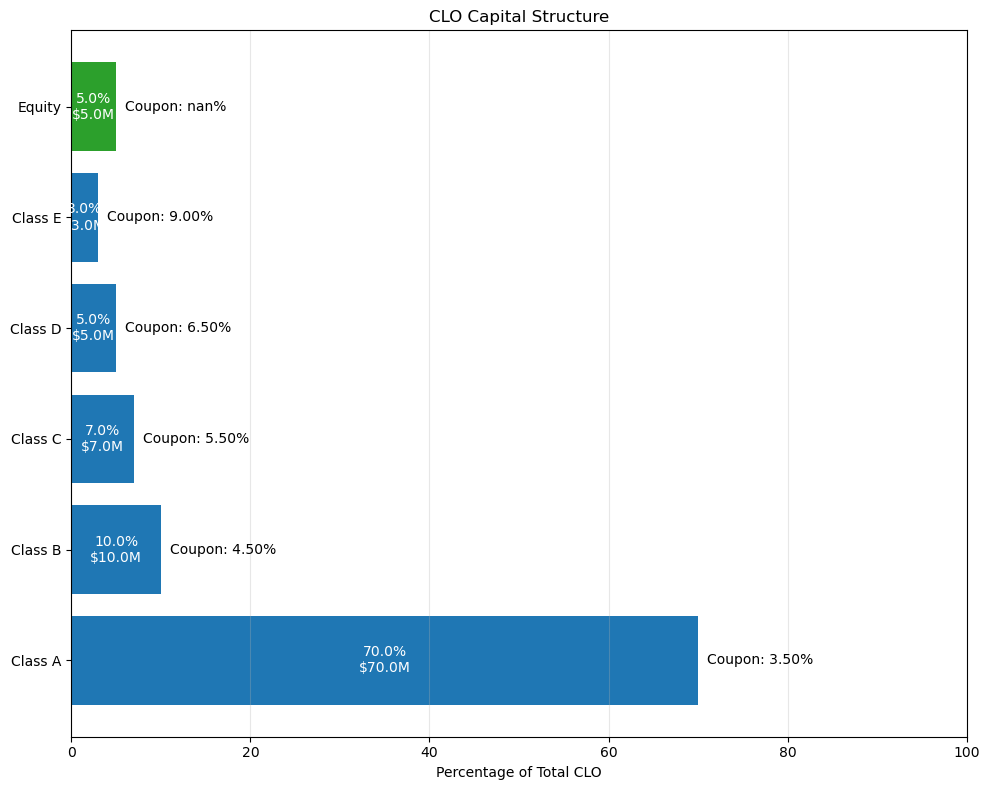

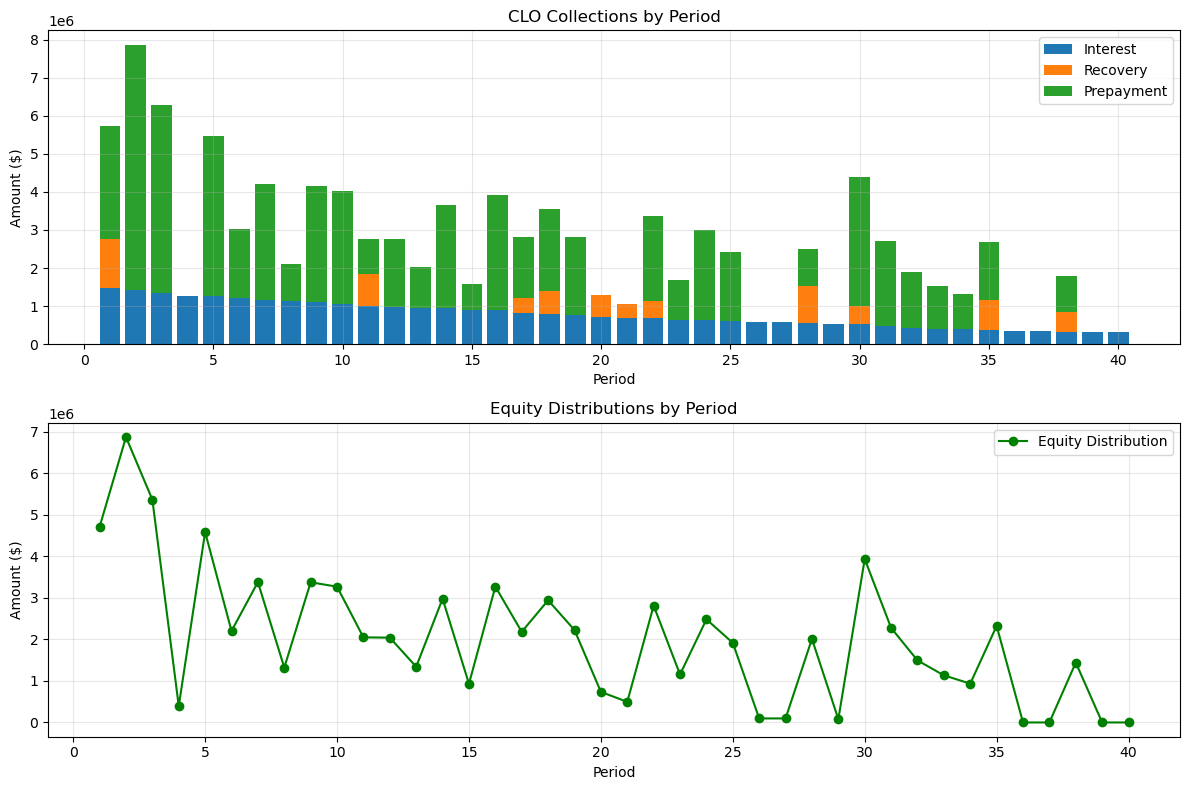

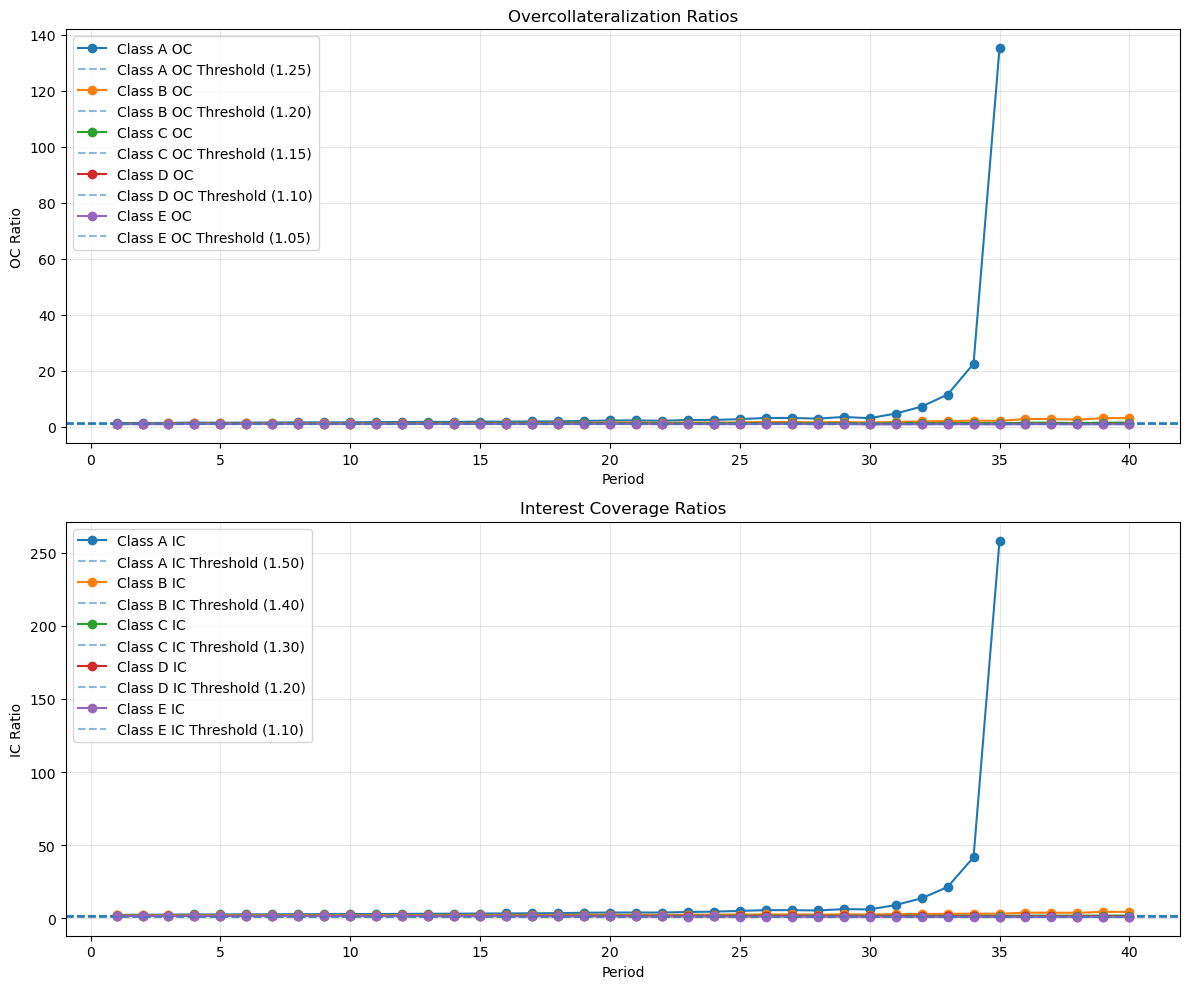

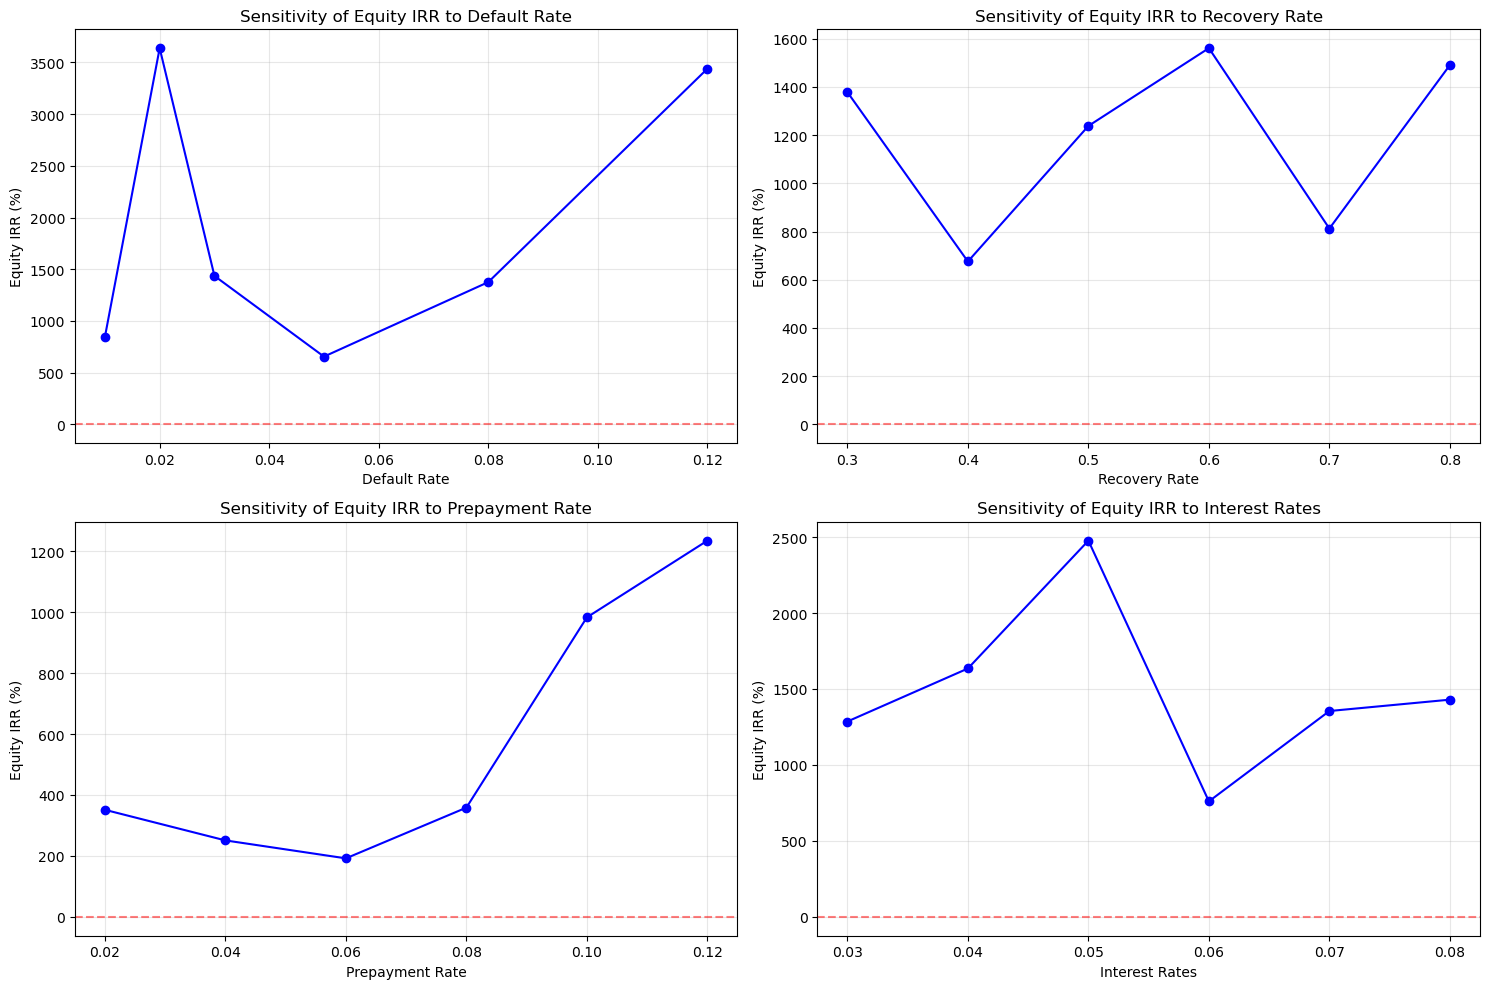

In [15]:
if __name__ == "__main__":
    # Run the example
    results = run_clo_example()
    
    # To show plots in interactive mode
    plt.show()